<a href="https://www.kaggle.com/code/faryalrifaz3374/sentiment-analysis-for-tweets?scriptVersionId=264604123" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Project : Sentiment Analysis on Tweets**  

## **Auther: Faryal Rifaz** 

##  **Objective**  
The objective of this project is to build a sentiment analysis tool using Python and NLTK to classify tweets as **positive, negative, or neutral**.  

---

##  Step 1: Import Libraries  

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import string
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import emoji
nltk.download('punkt')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras.layers import LSTM, Dense, SimpleRNN, Embedding, Flatten, Dropout
from keras.activations import softmax
from sklearn.model_selection import train_test_split
# ignore warnings   
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2025-09-29 05:14:22.548939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759122862.745849      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759122862.799124      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Step 2: Import Data 

In [2]:
import pandas as pd

# Training dataset
train = pd.read_csv(
    "/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv",
    header=None,
    names=["ID", "Topic", "Sentiment", "Text"]
)

# Validation dataset
valid = pd.read_csv(
    "/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv",
    header=None,
    names=["ID", "Topic", "Sentiment", "Text"]
)

# Show top rows 

train.head()


,ID,Topic,Sentiment,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Topic      74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [4]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1000 non-null   int64 
 1   Topic      1000 non-null   object
 2   Sentiment  1000 non-null   object
 3   Text       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [5]:
train.describe()

,ID
count,74682.000000
mean,6432.586165
std,3740.427870
min,1.000000
25%,3195.000000
50%,6422.000000
75%,9601.000000
max,13200.000000


In [6]:
valid.describe()

,ID
count,1000.000000
mean,6432.088000
std,3728.310569
min,6.000000
25%,3247.750000
50%,6550.000000
75%,9661.750000
max,13197.000000


## Step 3: Preprocessing

In this step, we clean the raw tweet texts to make them suitable for analysis.  
The preprocessing pipeline includes:
1- Converting text to lowercase  
2- Removing URLs, mentions, hashtags, punctuation, and special characters  
3- Tokenization (splitting sentences into words)  
4- Stopword removal (removing common words like "the", "is", "at")  
5- Lemmatization (converting words to their base form, e.g., "running" → "run")  

This ensures that the machine learning model focuses only on meaningful information.


In [7]:
import re
import html
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# download resources 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# stopwords & lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = html.unescape(text)                 # decode HTML
    text = text.lower()                        # lowercase
    text = re.sub(r'http\S+|www\.\S+', ' ', text)   # remove urls
    text = re.sub(r'@\w+', ' ', text)          # remove mentions
    text = re.sub(r'#', ' ', text)             # remove hash only
    text = re.sub(r'[^a-z0-9\s]', ' ', text)   # keep alnum + spaces
    tokens = nltk.word_tokenize(text)          # tokenize
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]  # lemmatize
    return " ".join(tokens)

# apply on both datasets
train['clean_text'] = train['Text'].apply(clean_text)
valid['clean_text'] = valid['Text'].apply(clean_text)

# check sample
print(train[['Text','clean_text']].head(10))


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


                                                Text  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   
5  im getting into borderlands and i can murder y...   
6  So I spent a few hours making something for fu...   
7  So I spent a couple of hours doing something f...   
8  So I spent a few hours doing something for fun...   
9  So I spent a few hours making something for fu...   

                                          clean_text  
0                       im getting borderland murder  
1                                 coming border kill  
2                         im getting borderland kill  
3                        im coming borderland murder  
4                       im getting borderland murder  
5                       im getting borderland murder 

## Step 4: Encode labels 

In [8]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#  Label encoding, fit on combined labels to ensure consistent mapping
le = LabelEncoder()
le.fit(pd.concat([train['Sentiment'], valid['Sentiment']], axis=0))
train['label_enc'] = le.transform(train['Sentiment'])
valid['label_enc'] = le.transform(valid['Sentiment'])
print("Label mapping (index -> label):", dict(enumerate(le.classes_)))

# Show class distribution
print("\nTrain class counts:\n", train['Sentiment'].value_counts())
print("\nValid class counts:\n", valid['Sentiment'].value_counts())

Label mapping (index -> label): {0: 'Irrelevant', 1: 'Negative', 2: 'Neutral', 3: 'Positive'}

Train class counts:
 Sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

Valid class counts:
 Sentiment
Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: count, dtype: int64


## Step 5: TF-IDF

In [9]:
# TF-IDF vectorization
tfv = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')
X_train = tfv.fit_transform(train['clean_text'])
X_valid = tfv.transform(valid['clean_text'])
y_train = train['label_enc']
y_valid = valid['label_enc']

print("\nTF-IDF matrix shapes, X_train, X_valid:", X_train.shape, X_valid.shape)


TF-IDF matrix shapes, X_train, X_valid: (74682, 10000) (1000, 10000)


## Step 6: Compare Multiple Models

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Linear SVM": LinearSVC(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    acc = accuracy_score(y_valid, preds)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

# Convert results to DataFrame for easy plotting
res_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])



Logistic Regression Accuracy: 0.8610
Naive Bayes Accuracy: 0.7470
Decision Tree Accuracy: 0.8860
Random Forest Accuracy: 0.9480
Linear SVM Accuracy: 0.9060


## Step 7:  Visualization

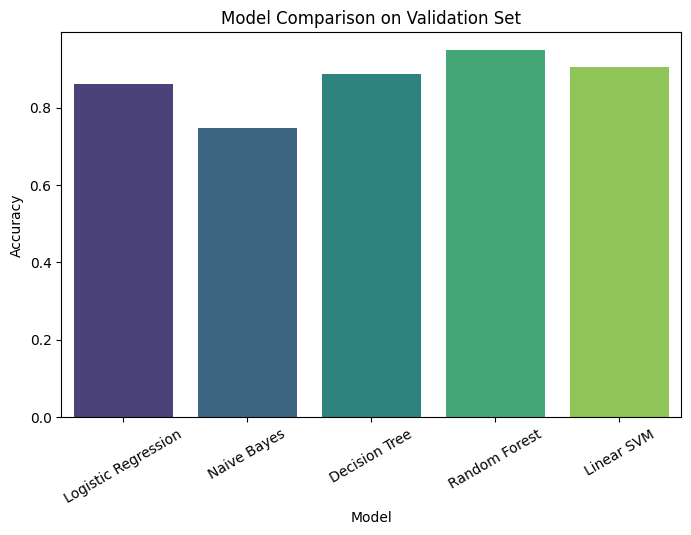

In [11]:

plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Accuracy", data=res_df, palette="viridis")
plt.title("Model Comparison on Validation Set")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.show()


## Step 8: Evaluation


Logistic Regression Accuracy: 0.8610
              precision    recall  f1-score   support

  Irrelevant       0.86      0.78      0.82       172
    Negative       0.82      0.91      0.86       266
     Neutral       0.92      0.85      0.89       285
    Positive       0.85      0.87      0.86       277

    accuracy                           0.86      1000
   macro avg       0.86      0.85      0.86      1000
weighted avg       0.86      0.86      0.86      1000

Confusion Matrix for Logistic Regression:


<Figure size 1200x800 with 0 Axes>

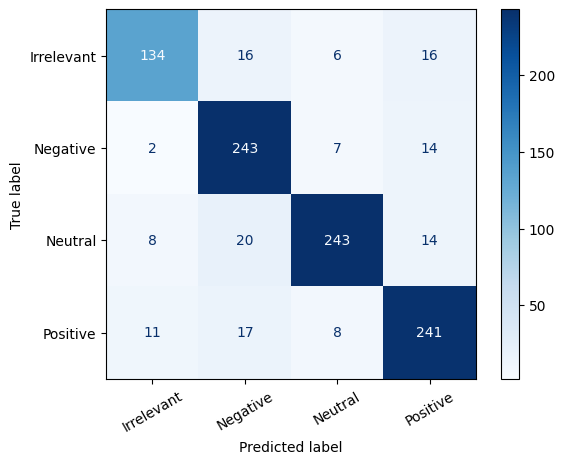

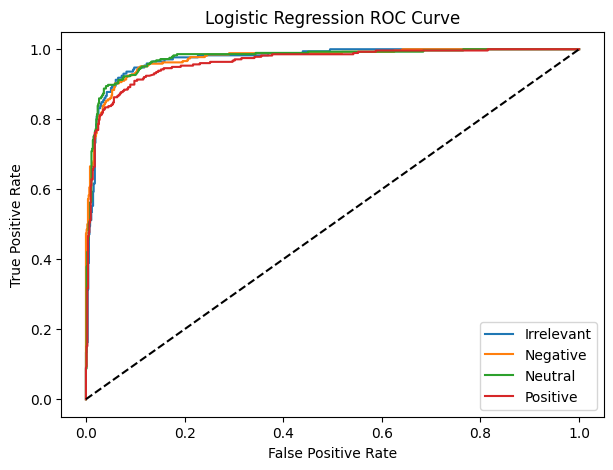


Naive Bayes Accuracy: 0.7470
              precision    recall  f1-score   support

  Irrelevant       0.85      0.58      0.69       172
    Negative       0.68      0.85      0.75       266
     Neutral       0.81      0.66      0.73       285
    Positive       0.74      0.85      0.79       277

    accuracy                           0.75      1000
   macro avg       0.77      0.73      0.74      1000
weighted avg       0.76      0.75      0.74      1000

Confusion Matrix for Naive Bayes:


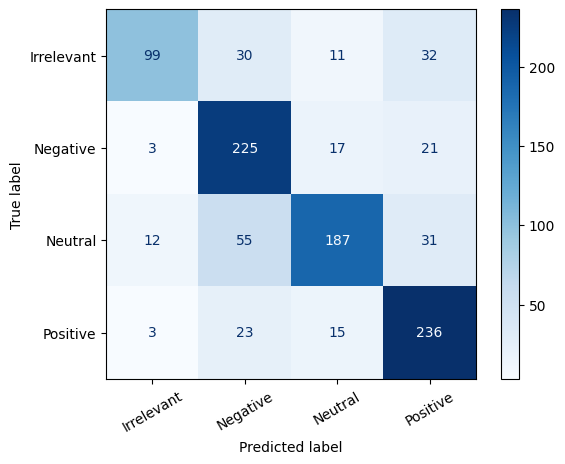

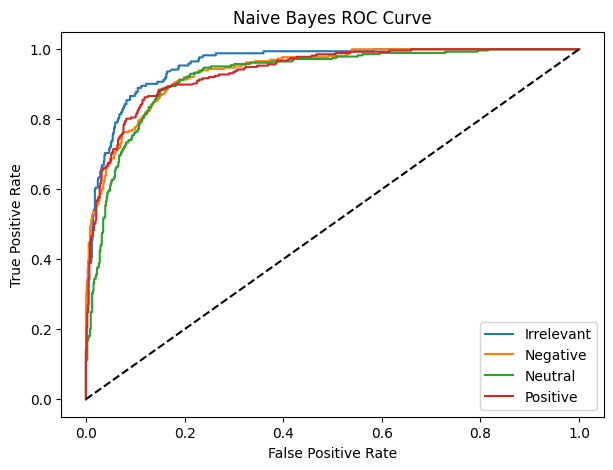


Decision Tree Accuracy: 0.8860
              precision    recall  f1-score   support

  Irrelevant       0.91      0.87      0.89       172
    Negative       0.87      0.92      0.89       266
     Neutral       0.90      0.86      0.88       285
    Positive       0.88      0.88      0.88       277

    accuracy                           0.89      1000
   macro avg       0.89      0.88      0.89      1000
weighted avg       0.89      0.89      0.89      1000

Confusion Matrix for Decision Tree:


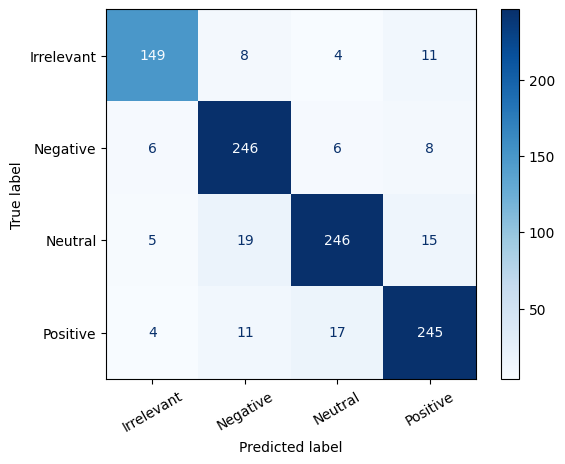

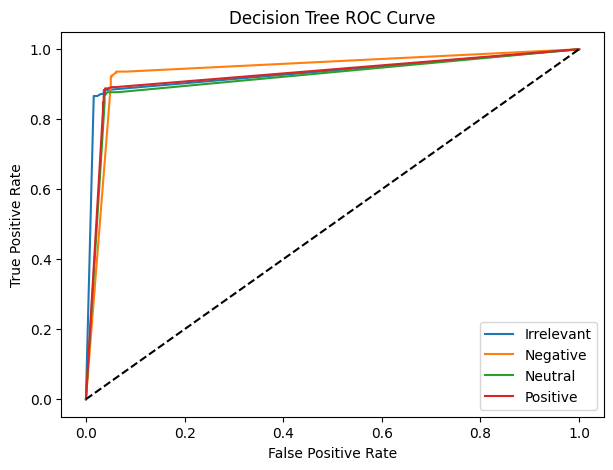


Random Forest Accuracy: 0.9480
              precision    recall  f1-score   support

  Irrelevant       0.97      0.92      0.95       172
    Negative       0.93      0.96      0.95       266
     Neutral       0.96      0.94      0.95       285
    Positive       0.94      0.96      0.95       277

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000

Confusion Matrix for Random Forest:


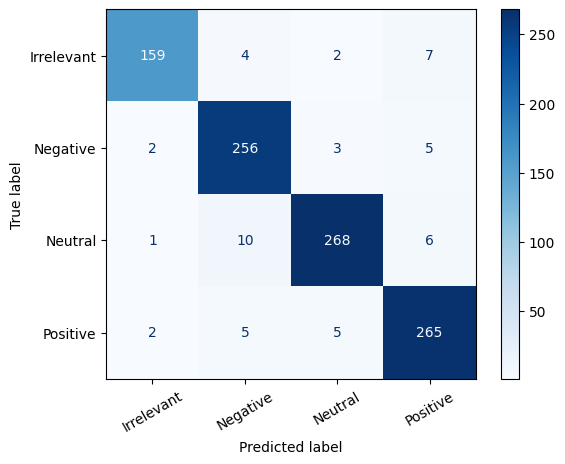

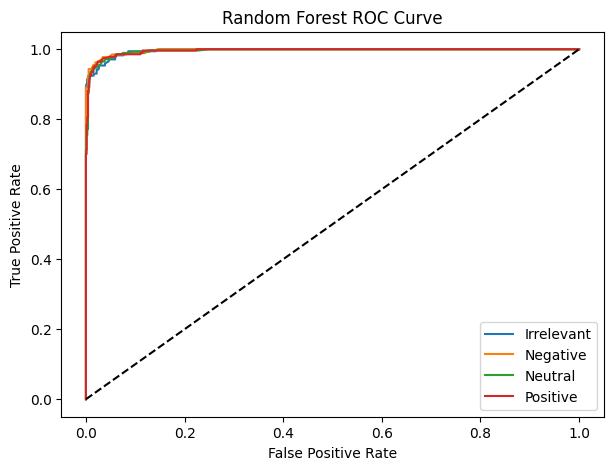


Linear SVM Accuracy: 0.9060
              precision    recall  f1-score   support

  Irrelevant       0.90      0.87      0.88       172
    Negative       0.88      0.95      0.91       266
     Neutral       0.96      0.91      0.93       285
    Positive       0.89      0.89      0.89       277

    accuracy                           0.91      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.91      0.91      1000

Confusion Matrix for Linear SVM:


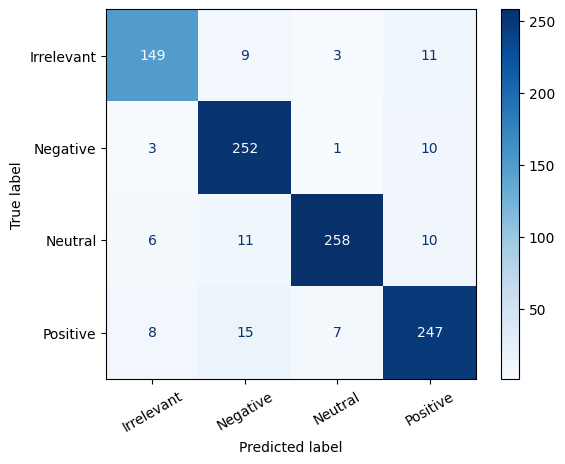

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

# Binarize labels for ROC
y_valid_bin = label_binarize(y_valid, classes=range(len(le.classes_)))
n_classes = y_valid_bin.shape[1]

plt.figure(figsize=(12, 8))

for idx, (name, model) in enumerate(models.items(), 1):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    # Accuracy
    acc = accuracy_score(y_valid, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    
    # Classification report
    print(classification_report(y_valid, y_pred, target_names=le.classes_))
    
    # Confusion matrix
    print(f"Confusion Matrix for {name}:")
    disp = ConfusionMatrixDisplay.from_estimator(model, X_valid, y_valid,
                                                 display_labels=le.classes_,
                                                 cmap='Blues',
                                                 xticks_rotation=30)
    
    # ROC curve for multiclass
    y_score = model.predict_proba(X_valid) if hasattr(model, "predict_proba") else None
    if y_score is not None:
        plt.figure(figsize=(7,5))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_valid_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, label=f"{le.classes_[i]}")
        plt.plot([0,1], [0,1], 'k--')
        plt.title(f"{name} ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()


## Step 9: Final Model 

In [13]:
# Random Forest chosen as final model
print("Final Model Selected: Random Forest")

# Retrain on full dataset
X_full = tfv.fit_transform(pd.concat([train['clean_text'], valid['clean_text']], axis=0))
y_full = pd.concat([train['label_enc'], valid['label_enc']], axis=0)

final_model = RandomForestClassifier(n_estimators=200, random_state=42)
final_model.fit(X_full, y_full)

# Save final model and preprocessing objects
import joblib
joblib.dump(final_model, "final_random_forest.pkl")
joblib.dump(tfv, "final_tfidf_vectorizer.pkl")
joblib.dump(le, "final_label_encoder.pkl")

print("\nFinal model and preprocessing objects saved successfully")


Final Model Selected: Random Forest

Final model and preprocessing objects saved successfully


## Step 10: Conclusion

The Random Forest classifier showed high performance for tweet sentiment analysis, achieving the best accuracy among applied models. 

---